# Setup

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode (connected = True)

from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# color palette
palette_1 = sns.cubehelix_palette(n_colors=5, rot=0.2, dark=0.25)
palette_2 = sns.cubehelix_palette(n_colors=2, rot=0.2, dark=0.5)

In [2]:
# Load Train and Test dataset
df_train = pd.read_csv("/kaggle/input/playground-series-s3e3/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e3/test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1119 non-null   int64 
 1   Age                       1119 non-null   int64 
 2   BusinessTravel            1119 non-null   object
 3   DailyRate                 1119 non-null   int64 
 4   Department                1119 non-null   object
 5   DistanceFromHome          1119 non-null   int64 
 6   Education                 1119 non-null   int64 
 7   EducationField            1119 non-null   object
 8   EmployeeCount             1119 non-null   int64 
 9   EnvironmentSatisfaction   1119 non-null   int64 
 10  Gender                    1119 non-null   object
 11  HourlyRate                1119 non-null   int64 
 12  JobInvolvement            1119 non-null   int64 
 13  JobLevel                  1119 non-null   int64 
 14  JobRole                 

In [5]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,1677.0,838.000000,484.252517,0.0,419.0,838.0,1257.0,1676.0
Age,1677.0,36.036971,8.507112,18.0,30.0,35.0,41.0,60.0
DailyRate,1677.0,892.749553,374.496259,107.0,589.0,890.0,1223.0,3921.0
DistanceFromHome,1677.0,8.683959,7.826143,1.0,2.0,7.0,12.0,29.0
Education,1677.0,2.937984,1.039078,1.0,2.0,3.0,4.0,15.0
EmployeeCount,1677.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EnvironmentSatisfaction,1677.0,2.757901,1.086835,1.0,2.0,3.0,4.0,4.0
HourlyRate,1677.0,67.798450,19.435928,30.0,51.0,69.0,84.0,100.0
JobInvolvement,1677.0,2.782349,0.650664,1.0,2.0,3.0,3.0,4.0
JobLevel,1677.0,1.998807,1.083065,1.0,1.0,2.0,2.0,7.0


**About the dataset:**

* Train dataset has 35 columns and 1677 records whereas test dataset has 34 columns (without the target column) and 1119 records.

* Both the train and test datasets do not contain NULL values.

* Train dataset:
    
    * Employees of the company have age between 18 and 60. Average age of an employee is 36.
    * Average values of daily rate, hourly rate, monthly rate and monthly income are 892, 68, 14770, 6196 respectively.
    * Mean performance rating is 3.12.

In [6]:
df_train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


# EDA

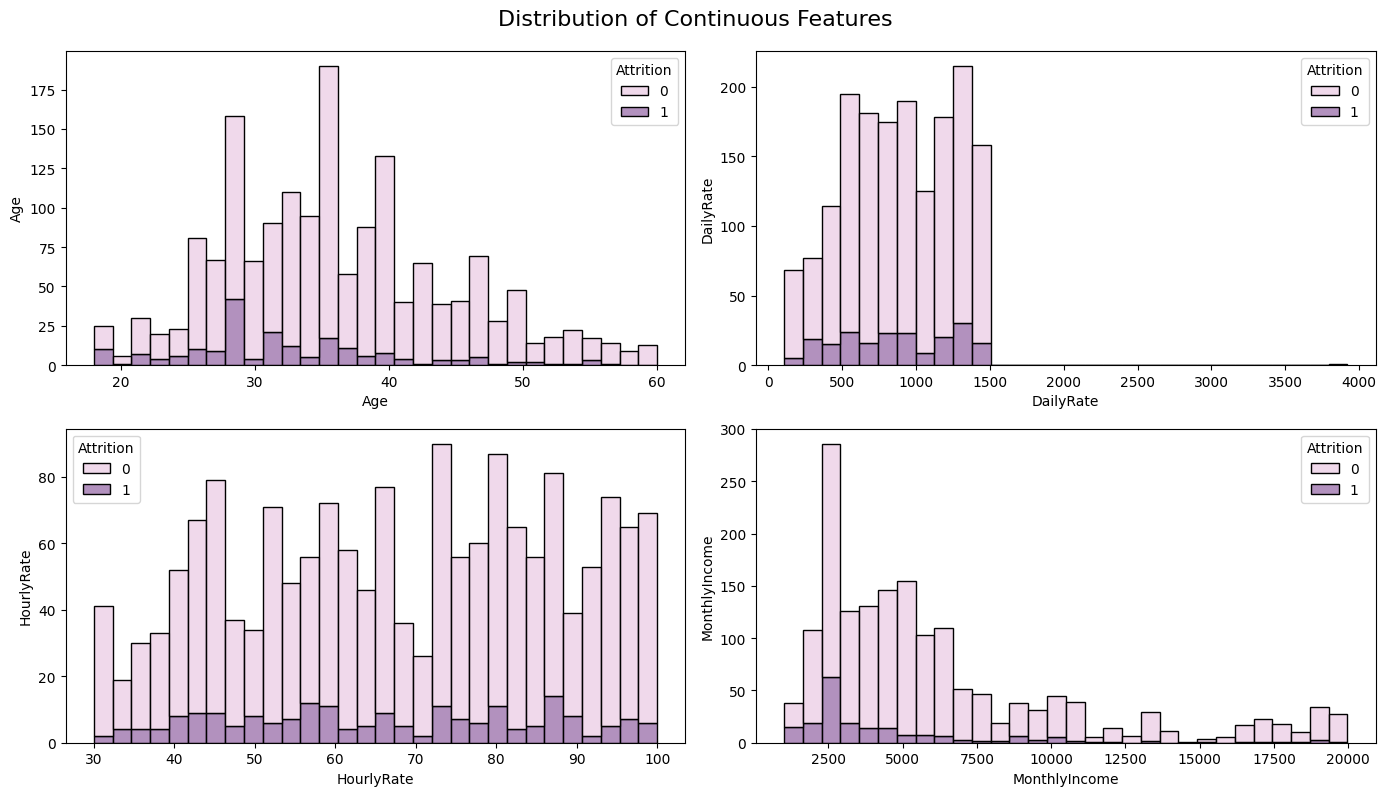

In [7]:
cols = ['Age', 'DailyRate',  'HourlyRate', 'MonthlyIncome']
              
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8), dpi=100)
fig.suptitle('Distribution of Continuous Features', y=0.99, fontsize=16);
for col, ax in zip(cols, axes.ravel()):
    sns.histplot(data=df_train, x=col, hue='Attrition', bins=30, palette=palette_2, ax=ax, multiple='stack')
    ax.set_ylabel(col)
        
plt.tight_layout()

In [8]:
attrition_perc = df_train['Attrition'].value_counts()
attrition_perc.index = ['Attrition_No', 'Attrition_Yes']

fig = px.pie(attrition_perc, values=attrition_perc.values, names=attrition_perc.index, 
             color_discrete_sequence=px.colors.sequential.Purp)

fig.update_traces(textposition='inside', textinfo='label+percent', rotation=112)
fig.update_layout(showlegend=False, title_text='Distribution of Target Label: Attrition', title_x=0.5)
fig.show()

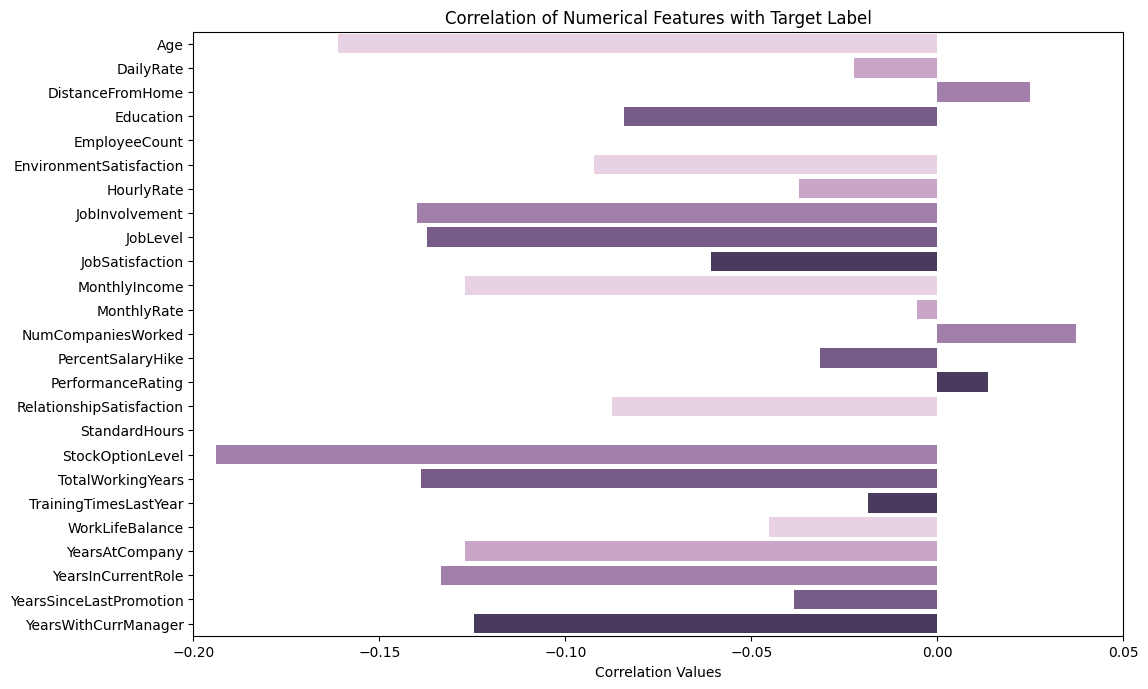

In [9]:
target_corr_num_features = df_train.corr()['Attrition'][1:-1]
plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(y = target_corr_num_features.index, x = target_corr_num_features.values, palette=palette_1)
plt.title('Correlation of Numerical Features with Target Label')
plt.xlabel('Correlation Values')
plt.xlim([-0.2, 0.05]);

**Observation:** Features like `EmployeeCount` and `StandardHours` have no correlation with the target label as they do not vary.

### Finding and removing outliers

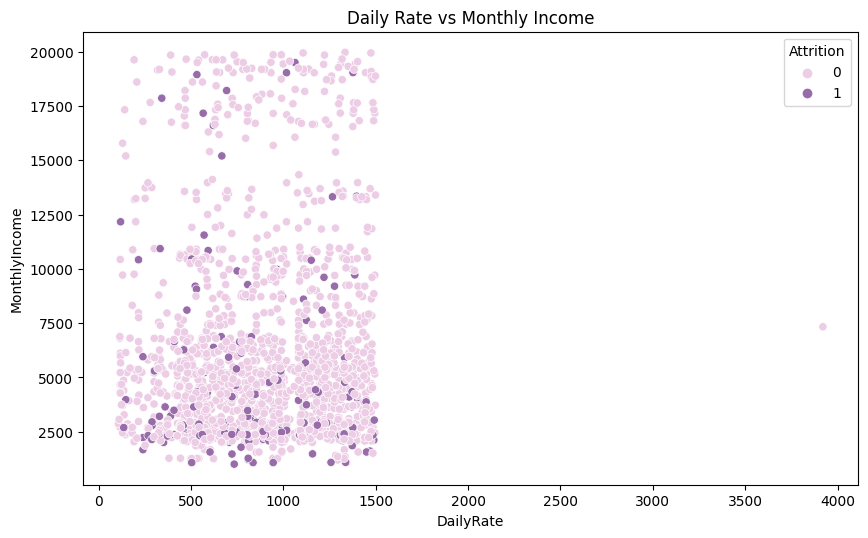

In [10]:
plt.figure(figsize=(10, 6), dpi=100)
sns.scatterplot(data=df_train, x='DailyRate', y='MonthlyIncome', hue='Attrition', palette=palette_2)
plt.title('Daily Rate vs Monthly Income');

In [11]:
# Removing the outlier
outlier_idx = df_train[df_train['DailyRate'] > 3500].index
df_train = df_train.drop(outlier_idx, axis=0).reset_index(drop=True)

### Visualization for Numerical Features

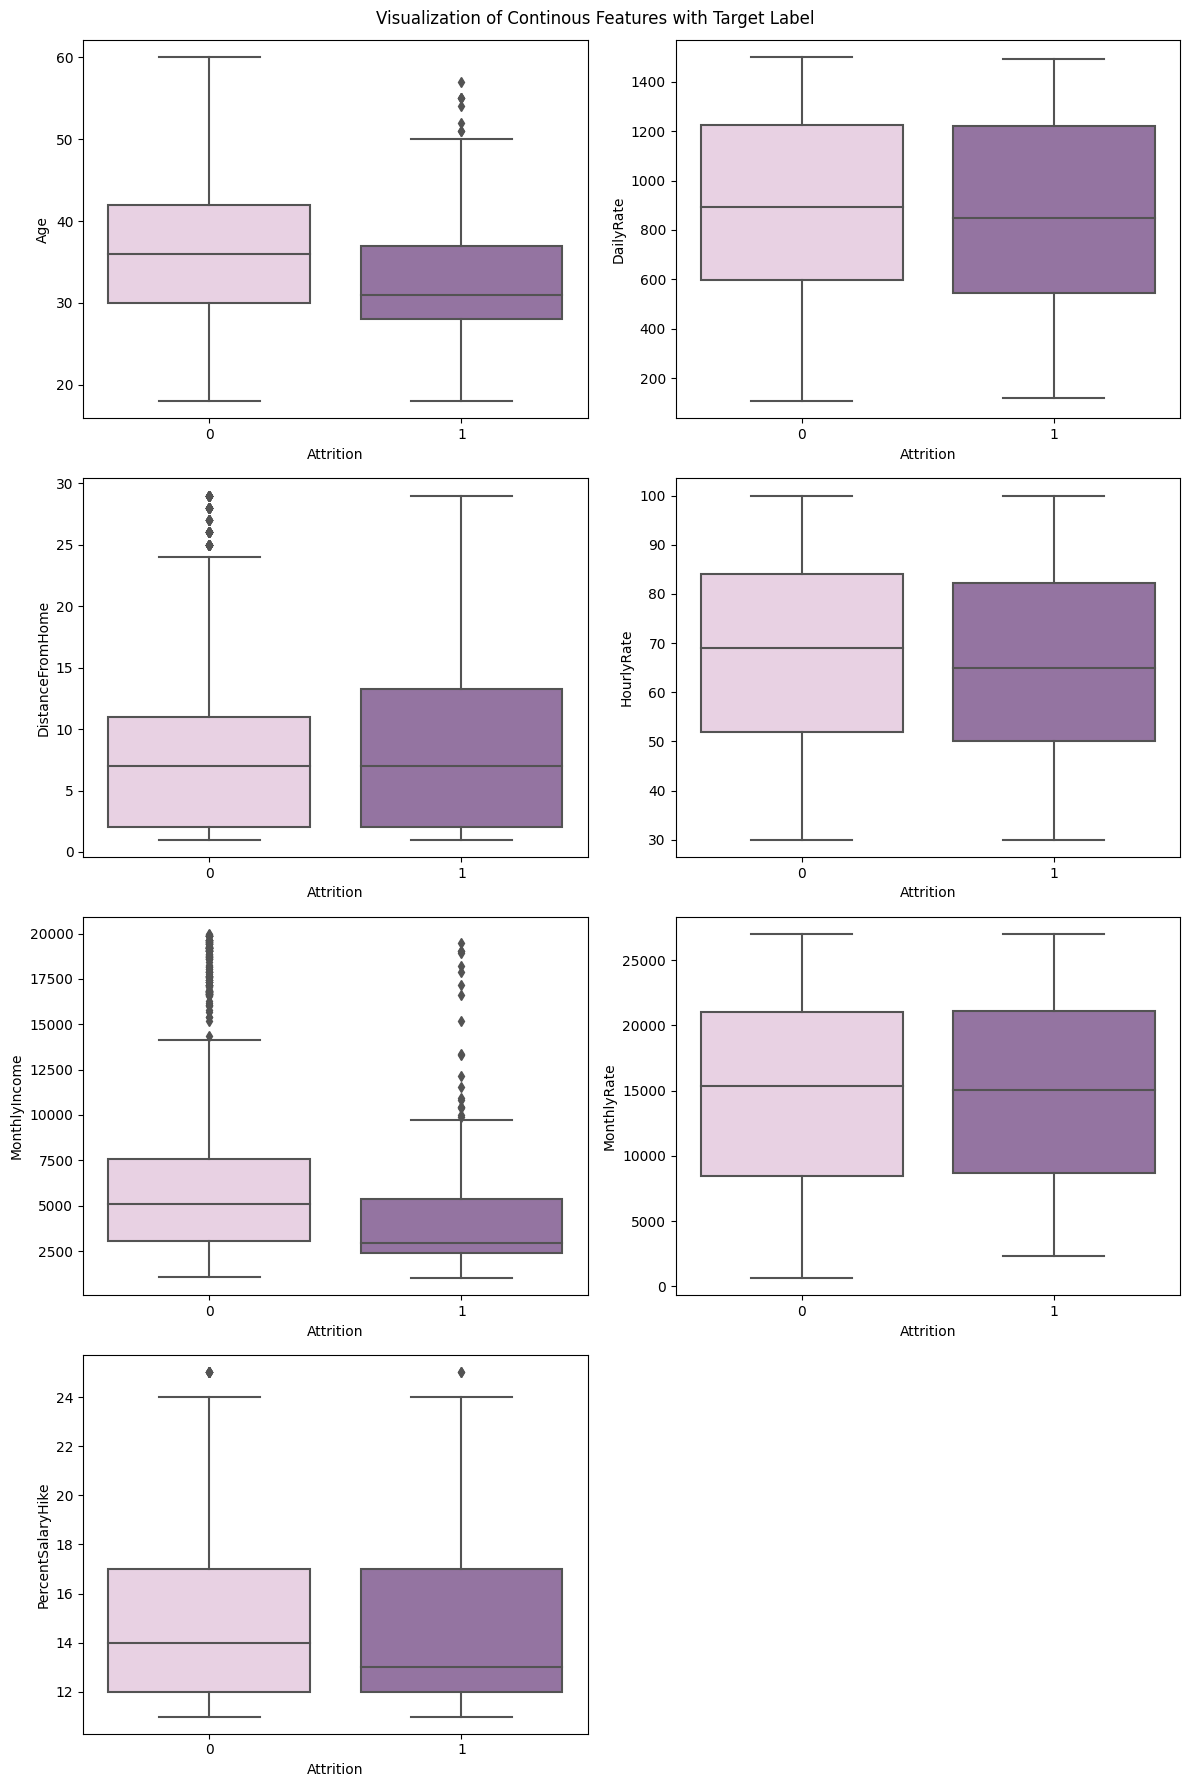

In [12]:
# Employees count for different numerical columns
num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'PercentSalaryHike']
              
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,18), dpi=100)
fig.suptitle('Visualization of Continous Features with Target Label', y=0.99);
for col, ax in zip(num_cols, axes.ravel()):
    sns.boxplot(data=df_train, y=col, x='Attrition', palette=palette_2, ax=ax)
    ax.set_ylabel(col)
    
fig.delaxes(axes[3,1])
    
plt.tight_layout()

### Visualization of Categorical Features

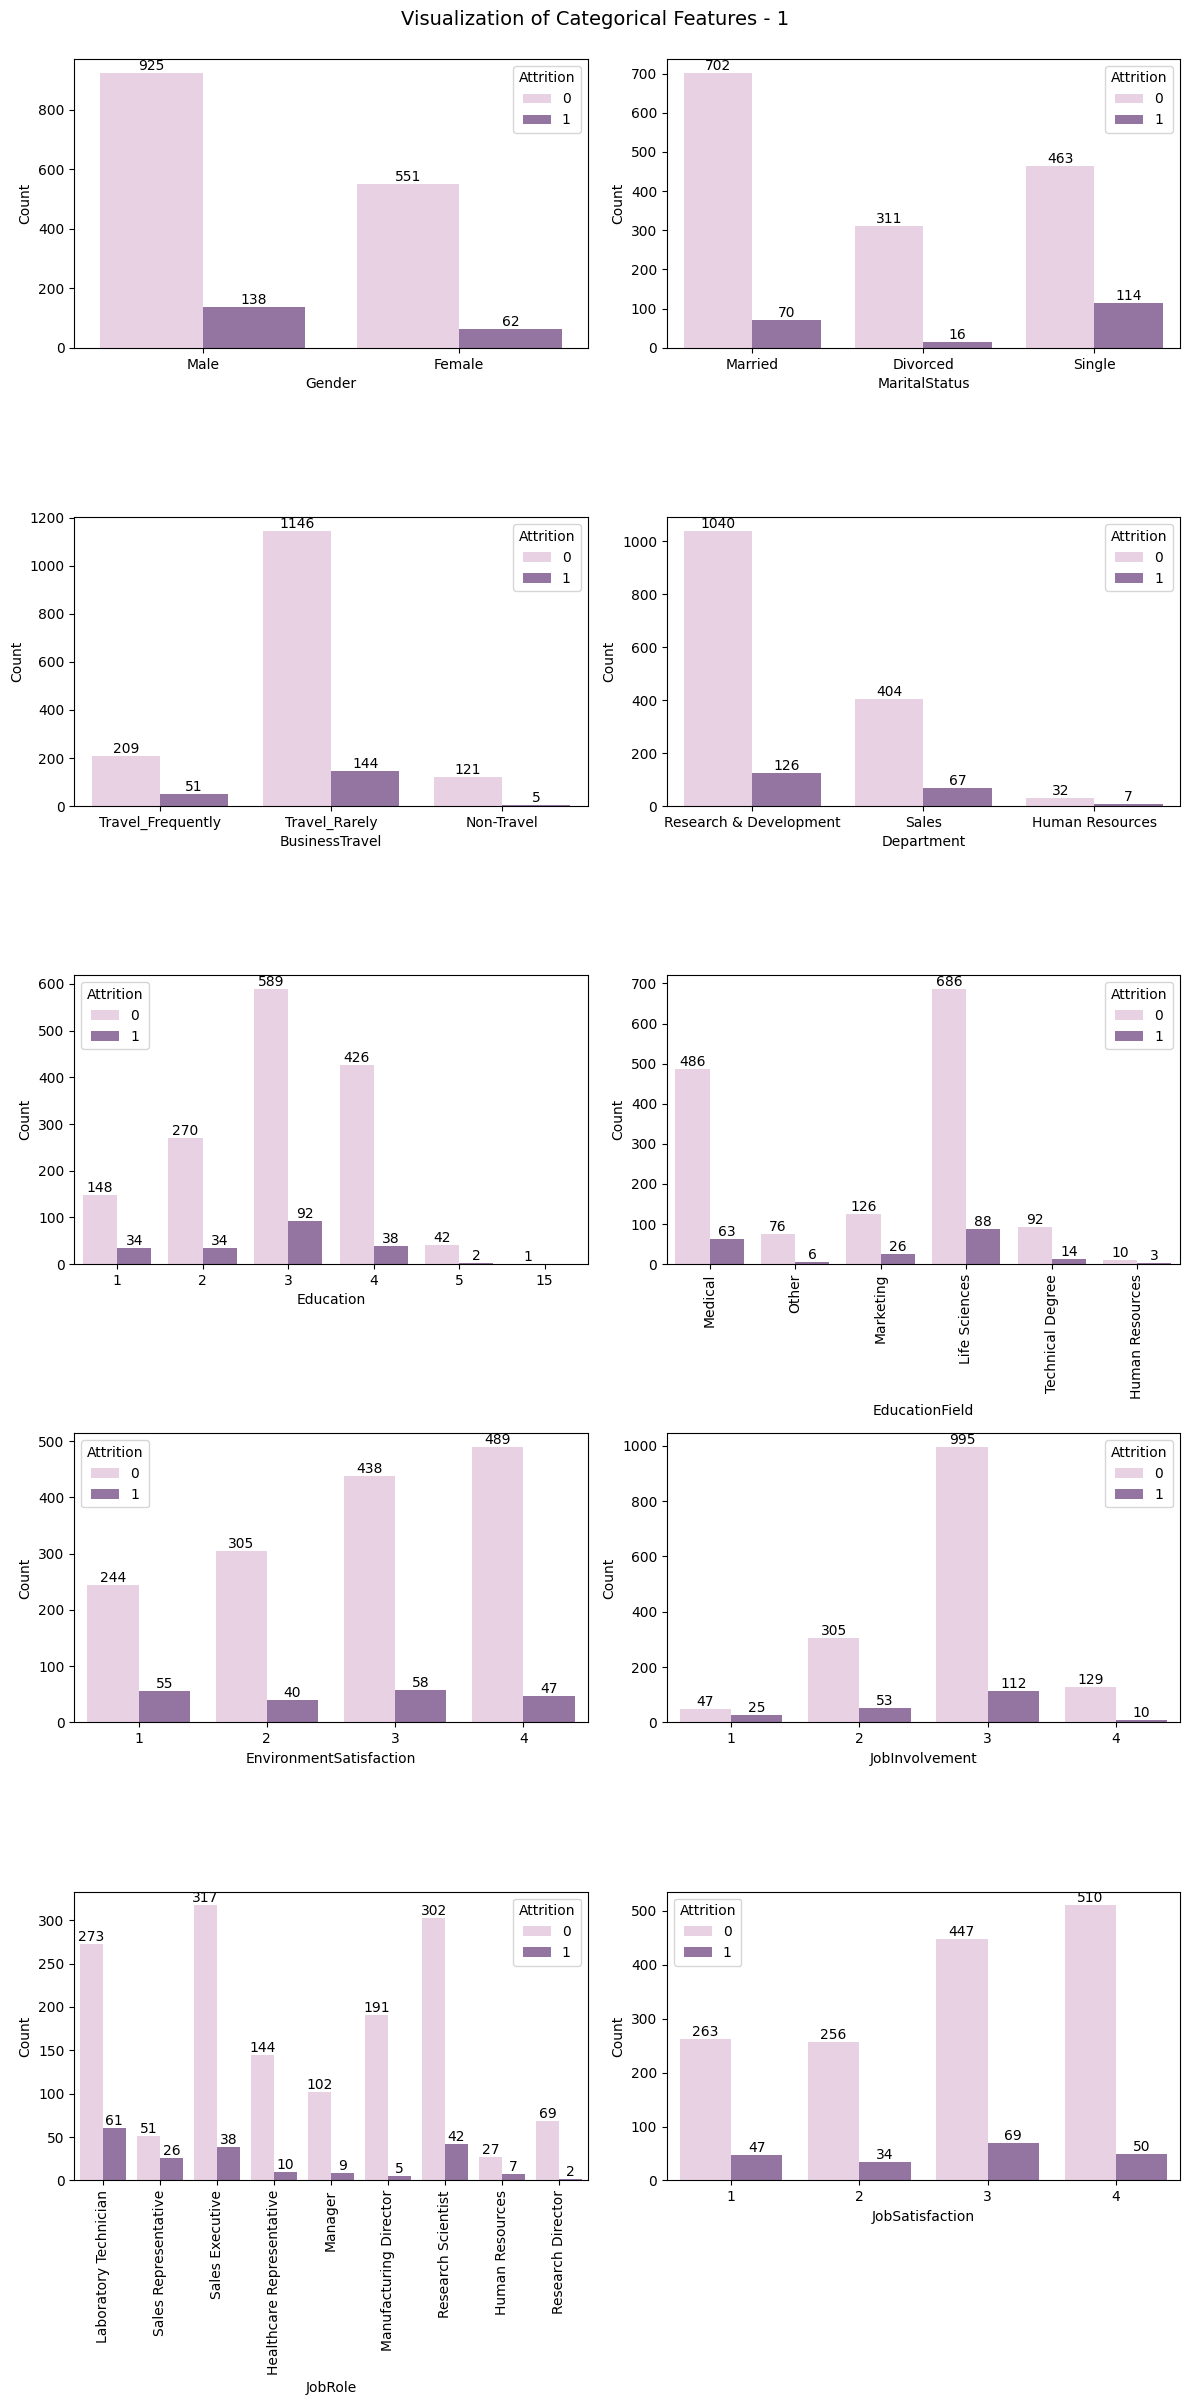

In [13]:
count_cols_1 = ['Gender', 'MaritalStatus', 'BusinessTravel', 'Department', 'Education', 'EducationField', 
              'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction'] 
              
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,24), dpi=100)
fig.suptitle('Visualization of Categorical Features - 1', y=1, fontsize=14);
for col, ax in zip(count_cols_1, axes.ravel()):
    sns.countplot(data=df_train, x=col, hue='Attrition', palette=palette_2, ax=ax)
    ax.set_ylabel('Count')
    if col == 'JobRole' or col == 'EducationField':
        ax.tick_params(axis='x', labelrotation=90)
    for i in ax.containers:
        ax.bar_label(i,)
    
plt.tight_layout()

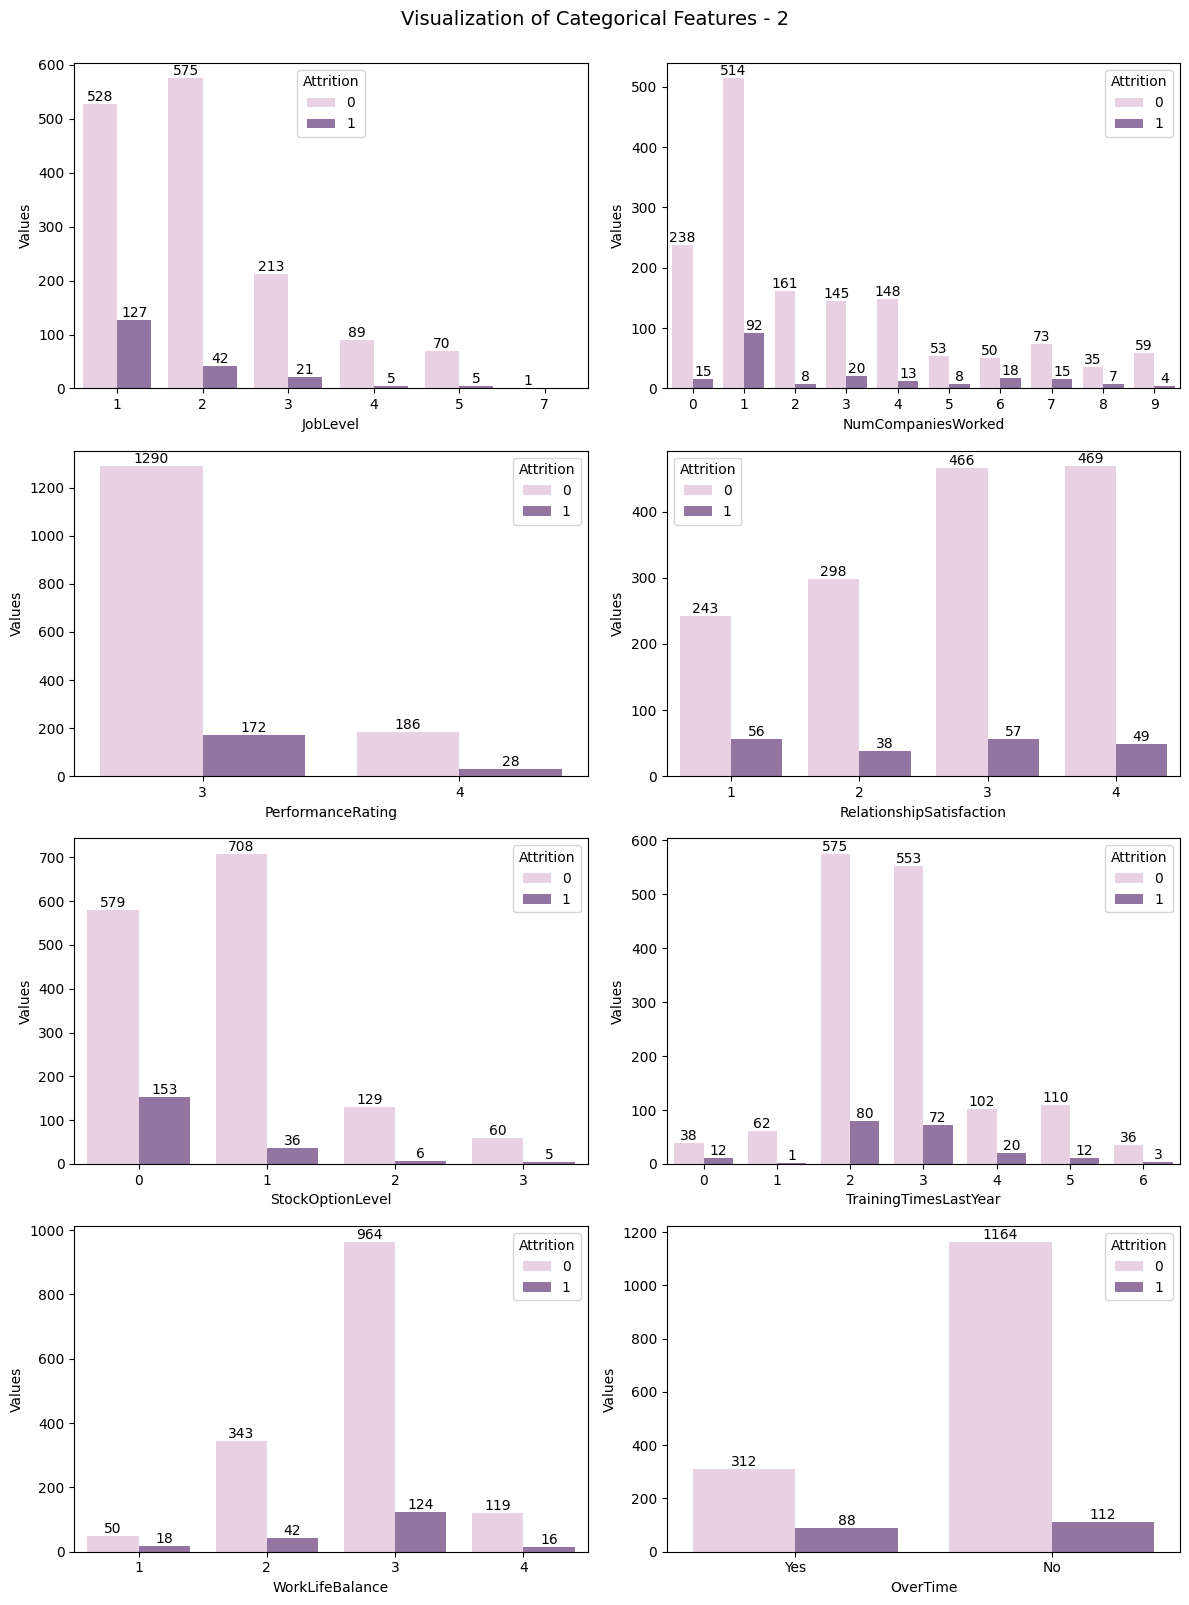

In [14]:
count_cols_2 = ['JobLevel', 'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction', 
                'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'OverTime']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,16), dpi=100)
fig.suptitle('Visualization of Categorical Features - 2', y=1, fontsize=14);
for col, ax in zip(count_cols_2, axes.ravel()):
    sns.countplot(data=df_train, x=col, hue='Attrition', palette=palette_2, ax=ax)
    ax.set_ylabel('Values')
    for i in ax.containers:
        ax.bar_label(i,)
    
plt.tight_layout()

### Annual Income of Employees

In [15]:
gender_income = round(12 * df_train.groupby('Gender')['MonthlyIncome'].mean(), 2)

fig = px.pie(gender_income, values=gender_income.values, names=gender_income.index, 
             color_discrete_sequence=px.colors.sequential.Purp)

fig.update_traces(textposition='inside', textinfo='label+value', rotation=0)
fig.update_layout(showlegend=False, title_text='Average Annual Income By Gender', title_x=0.5)
fig.show()

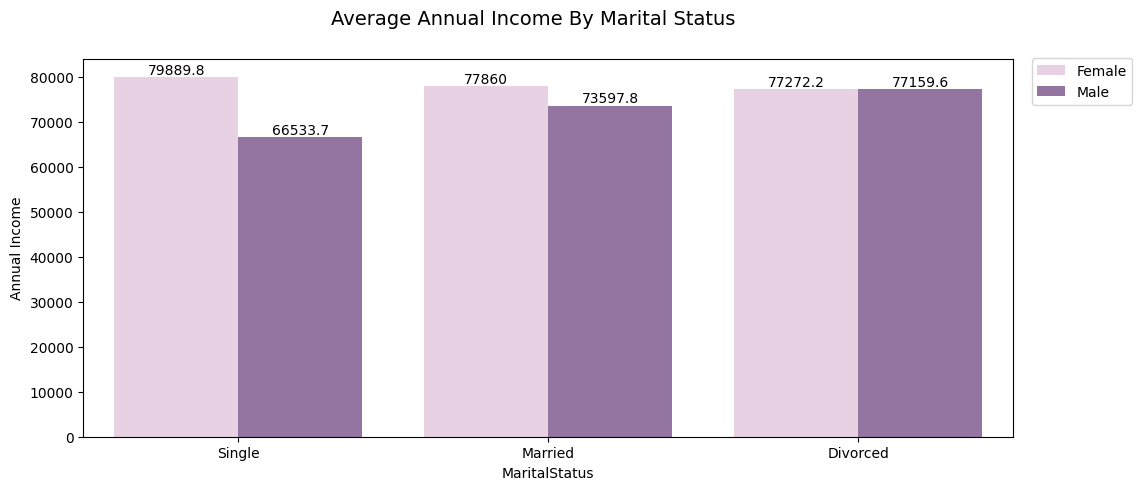

In [16]:
marital_st_income = round(12 * df_train.groupby(['MaritalStatus', 'Gender'])
                          ['MonthlyIncome'].mean(), 2).sort_values(ascending=False)

marital_st_income = marital_st_income.reset_index()
marital_st_income = marital_st_income.rename(columns={'MonthlyIncome' : 'Annual Income'})

fig, ax = plt.subplots(figsize=(12,5), dpi=100)
fig.suptitle('Average Annual Income By Marital Status', fontsize=14)
ax = sns.barplot(data=marital_st_income, x='MaritalStatus', y='Annual Income', palette=palette_2, hue='Gender')
for i in ax.containers:
    ax.bar_label(i,)
ax.legend(loc=(1.02, 0.88));

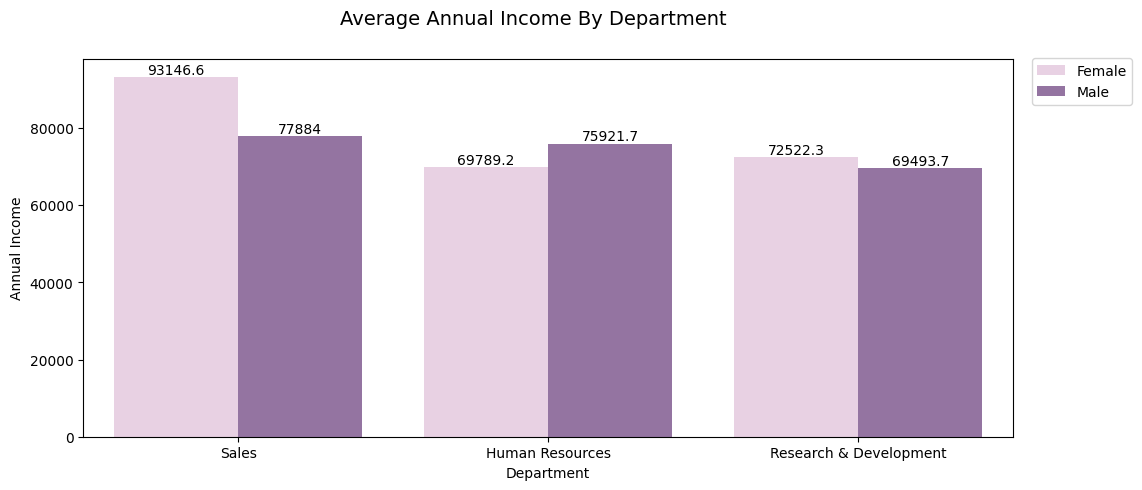

In [17]:
dept_income = round(12 * df_train.groupby(['Department', 'Gender'])
                          ['MonthlyIncome'].mean(), 2).sort_values(ascending=False)

dept_income = dept_income.reset_index()
dept_income = dept_income.rename(columns={'MonthlyIncome' : 'Annual Income'})

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
fig.suptitle('Average Annual Income By Department', fontsize=14)
ax = sns.barplot(data=dept_income, x='Department', y='Annual Income', palette=palette_2, hue='Gender')
for i in ax.containers:
    ax.bar_label(i,)
ax.legend(loc=(1.02, 0.88));

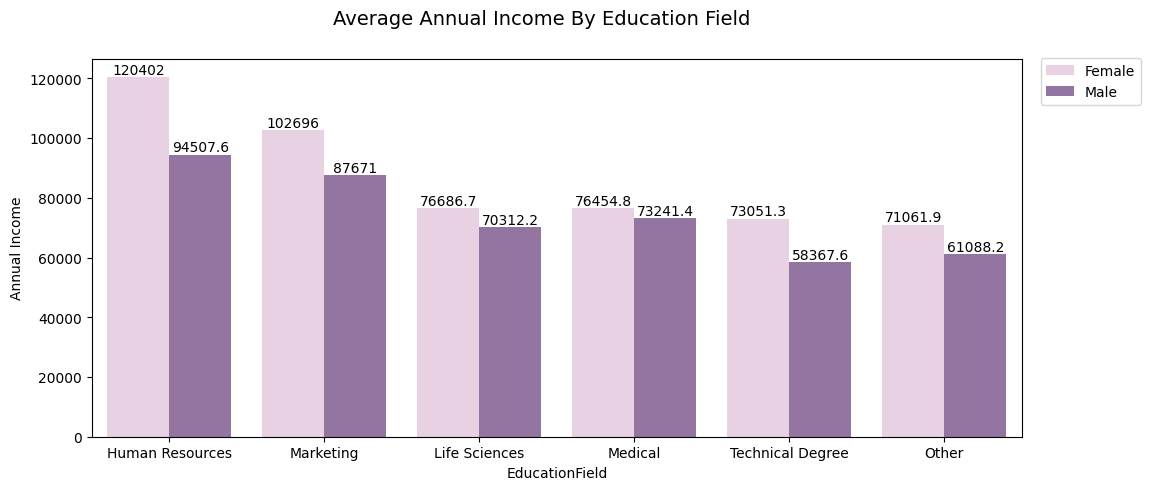

In [18]:
edu_income = round(12 * df_train.groupby(['EducationField', 'Gender'])
                          ['MonthlyIncome'].mean(), 2).sort_values(ascending=False)

edu_income = edu_income.reset_index()
edu_income = edu_income.rename(columns={'MonthlyIncome' : 'Annual Income'})

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
fig.suptitle('Average Annual Income By Education Field', fontsize=14)
ax = sns.barplot(data=edu_income, x='EducationField', y='Annual Income', palette=palette_2, hue='Gender')
for i in ax.containers:
    ax.bar_label(i,)
ax.legend(loc=(1.02, 0.88));

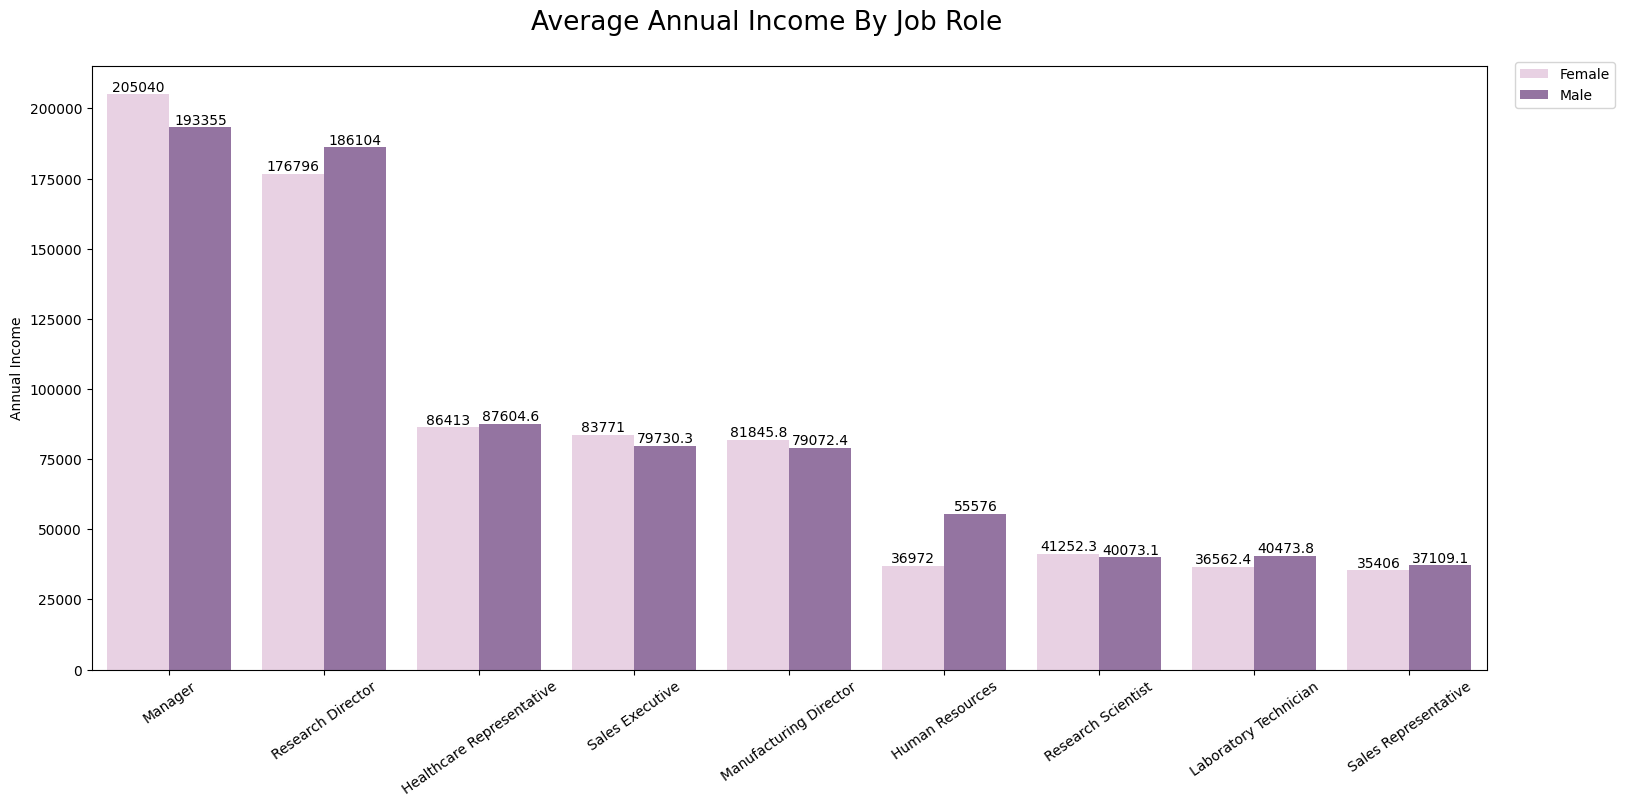

In [19]:
jobrole_income = round(12 * df_train.groupby(['JobRole', 'Gender'])
                          ['MonthlyIncome'].mean(), 2).sort_values(ascending=False)

jobrole_income = jobrole_income.reset_index()
jobrole_income = jobrole_income.rename(columns={'MonthlyIncome' : 'Annual Income'})

fig, ax = plt.subplots(figsize=(18, 8), dpi=100)
fig.suptitle('Average Annual Income By Job Role', fontsize=19, y=0.95)
ax = sns.barplot(data=jobrole_income, x='JobRole', y='Annual Income', palette=palette_2, hue='Gender')
for i in ax.containers:
    ax.bar_label(i,)
ax.legend(loc=(1.02, 0.93))
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=35);

### New Features



In [20]:
def cat_years_current_manager(value):
    if value < 5:
        return "Less than 5 years"
    elif (value >= 5) & (value <= 10):
        return "Between 5-10 years"
    else:
        return "More than 10 years"
    
def cat_years_at_company(value):
    if value < 5:
        return "Less than 5 years"
    elif (value >= 5) & (value <= 10):
        return "Between 5-10 years"
    elif (value >= 11) & (value <= 20):
        return "Between 11-20 years"
    elif (value >= 21) & (value <= 30):
        return "Between 21-30 years"
    else:
        return "More than 30 years"
    
def cat_years_current_role(value):
    if value < 5:
        return "Less than 5 years"
    elif (value >=5) & (value <= 10):
        return "Between 5-10 years"
    else:
        return "More than 10 years"

def cat_years_since_last_promotion(value):
    if value < 5:
        return "Less than 5 years"
    elif (value >=5) & (value <= 10):
        return "Between 5-10 years"
    else:
        return "More than 10 years"
    
def cat_distance_home(value):
    if value < 5:
        return "Less than 5 km"
    elif (value >=5) & (value <= 10):
        return "Between 5-10 km"
    elif (value >= 11) & (value <= 20):
        return "Between 11-20 km"
    else:
        return "Above 20 km"
    
def cat_age(value):
    if value <= 20:
        return "Between 18-20 years"
    elif (value > 20) & (value <= 30):
        return "Between 21-30 years"
    elif (value > 31) & (value <= 40):
        return "Between 31-40 years"
    elif (value > 41) & (value <= 50):
        return "Between 41-50 years"
    else:
        return "Above 50 years"
    
df_train['Cat_YearsWithCurrManager'] = df_train['YearsWithCurrManager'].apply(cat_years_current_manager)

df_train['Cat_YearsAtCompany'] = df_train['YearsAtCompany'].apply(cat_years_at_company)

df_train['Cat_YearsInCurrentRole'] = df_train['YearsInCurrentRole'].apply(cat_years_current_role)

df_train['Cat_YearsSinceLastPromotion'] = df_train['YearsSinceLastPromotion'].apply(cat_years_since_last_promotion)

df_train['Cat_DistanceFromHome'] = df_train['DistanceFromHome'].apply(cat_distance_home)

df_train['OverallSatisfaction'] = np.round((df_train['EnvironmentSatisfaction'] + df_train['JobSatisfaction'] 
                                + df_train['JobInvolvement'] + df_train['RelationshipSatisfaction'] 
                                         + df_train['WorkLifeBalance'])/5).astype('int32')

df_train['Cat_Age'] = df_train['Age'].apply(cat_age)    

### Visualization of New Features

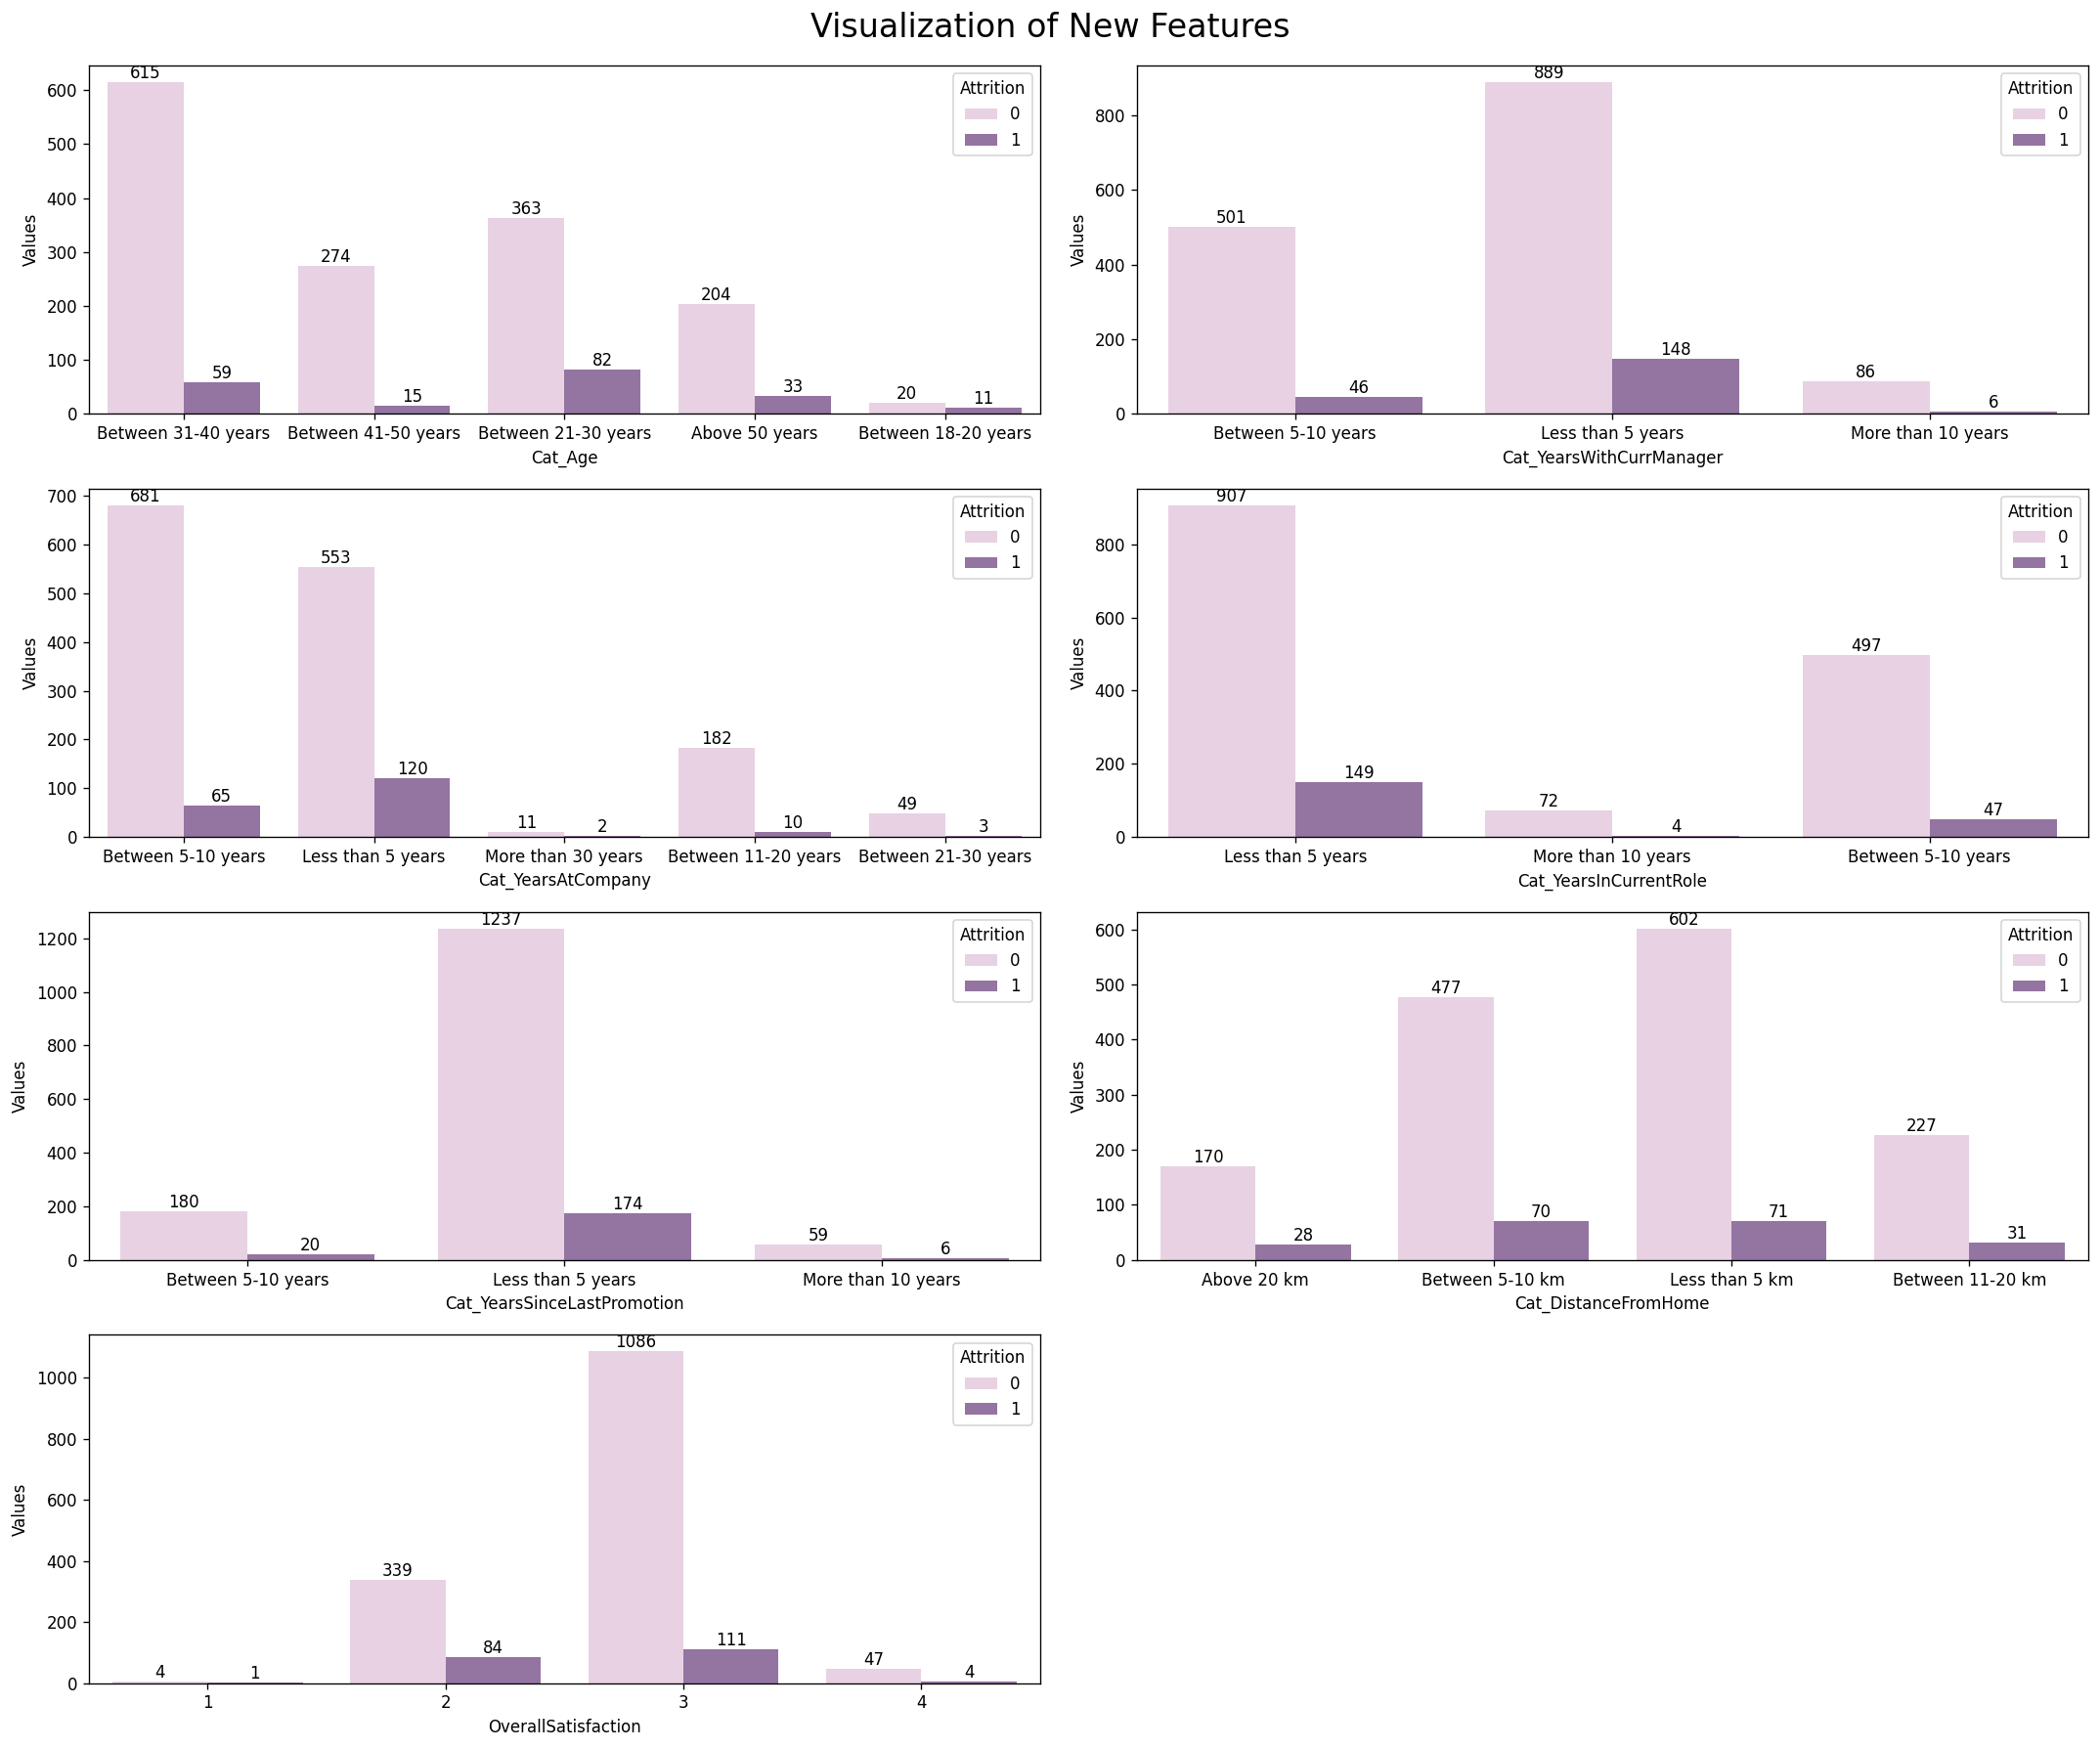

In [21]:
cat_cols = ['Cat_Age', 'Cat_YearsWithCurrManager', 'Cat_YearsAtCompany', 'Cat_YearsInCurrentRole', 'Cat_YearsSinceLastPromotion', 'Cat_DistanceFromHome', 'OverallSatisfaction']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,15), dpi=120)
fig.suptitle('Visualization of New Features', y=0.99, fontsize=20);
for col, ax in zip(cat_cols, axes.ravel()):
    sns.countplot(data=df_train, x=col, hue='Attrition', palette=palette_2, ax=ax)
    ax.set_ylabel('Values')
    for i in ax.containers:
        ax.bar_label(i,)
        
fig.delaxes(axes[3,1])
    
plt.tight_layout()


------

------

# Target Prediction with CatBoost Classifier

In [22]:
# Dropping the newly created features from the train dataset
df_train = df_train.drop(['Cat_YearsWithCurrManager', 'Cat_YearsAtCompany', 
                          'Cat_YearsInCurrentRole', 'Cat_YearsSinceLastPromotion', 
                          'Cat_DistanceFromHome', 'OverallSatisfaction', 'Cat_Age'], axis=1)

# Loading the IBM Employee Attrition dataset for training
df_orig = pd.read_csv("/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

df_orig['Attrition'] = df_orig['Attrition'].map({'Yes' : 1, 'No' : 0})

df_orig = df_orig.drop('EmployeeNumber', axis=1)

df_train = df_train.drop('id', axis=1)

# Concatenate original dataset with train dataset
df = pd.concat([df_orig, df_train]).reset_index(drop=True)

# Dropping features which are not necessary
df = df.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)

# Encode class labels using pandas get_dummies function
df_temp = df.copy()
df_temp = pd.get_dummies(df_temp, drop_first=True)

# Train set
X_train = df_temp.drop('Attrition', axis=1)
y_train = df_temp['Attrition']

# Test set
test_temp = df_test.copy()
test_temp = test_temp.drop(['id', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1)
test_temp = pd.get_dummies(test_temp, drop_first=True)

X_test = test_temp

In [23]:
# Perform cross validation with "area under the curve" as the scoring metric
seed = 8888

kfold = StratifiedKFold(n_splits=5)

cls_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

roc_auc_score = cross_val_score(cls_model, X_train, y_train, scoring='roc_auc', cv=kfold)


mean_roc_auc = np.mean(roc_auc_score)
print(f'Mean ROC-AUC Score: {mean_roc_auc}')    

Mean ROC-AUC Score: 0.8511073707285609


### Hyperparameter tuning

In [24]:
# GridSearchCV for finding the best hyperparameters for the CatBoost Model
# params = {'learning_rate': [0.03, 0.05, 0.1], 
#           'depth': [3, 5, 6, 10], 
#           'l2_leaf_reg': [1, 3, 5], 
#           'iterations' : np.arange(200, 550, 50)}

# cls_model = CatBoostClassifier(eval_metric='AUC', verbose=False)

# grid_cls = GridSearchCV(estimator=cls_model, param_grid=params, cv=kfold, scoring='roc_auc', n_jobs=-1, verbose=False)

# grid_cls.fit(X_train, y_train)

# catboost_params = grid_cls.best_params_

In [25]:
# Best parameters
catboost_params = {'depth': 5, 'iterations': 250, 'l2_leaf_reg': 5, 'learning_rate': 0.05}

In [26]:
# Train the model with best hyperparameters
cls_estimator = CatBoostClassifier(**catboost_params, eval_metric='AUC', verbose=False)
cls_estimator.fit(X_train, y_train)

### Target Prediction

In [27]:
y_pred_proba = cls_estimator.predict_proba(X_test)
y_pred = y_pred_proba[:, 1]

# Save the predicted target values into a dataframe
predictions = pd.DataFrame({'id' : df_test['id'], 'Attrition' : y_pred})
predictions['Attrition'] = round(predictions['Attrition'], 2)

predictions.head()

,id,Attrition
0,1677,0.20
1,1678,0.12
2,1679,0.06
3,1680,0.06
4,1681,0.54


In [28]:
output = predictions.to_csv("submission_employee_attrition_cb.csv", index=False)